Imports

In [1]:
import rasterio as ras
from rasterio.crs import CRS
import geopandas as gpd
import pandas as pd
import numpy as np 
import os
import sklearn.metrics as sm

### Load Data

Test Data


In [2]:
togo_test = gpd.read_file('data/HarvestData/togo.csv')
togo_test.head()

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country,geometry
0,-0.166017495138,11.161903923746,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,training,Togo,None
1,-0.163856380947,11.163925905434,2019-04-22,2020-04-16,crop_merged_v2,1.0,1,training,Togo,None
2,-0.15702497662,11.136826215839,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,training,Togo,None
3,-0.155683451678,11.159339899554,2019-04-22,2020-04-16,crop_merged_v2,1.0,1,validation,Togo,None
4,-0.155525161003,11.136066814782,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,training,Togo,None


Binary Datasets

In [3]:
togo_data = {}
dir = 'data/TogoBinaryMaps'

for tif in os.listdir(dir):
    f = os.path.join(dir, tif)
    togo_data["togo_" + tif[:-16:]] = ras.open(f)

togo_data
    

{'togo_AgreementMap': <open DatasetReader name='data/TogoBinaryMaps\AgreementMap_Togo_Binary.tif' mode='r'>,
 'togo_ASAP': <open DatasetReader name='data/TogoBinaryMaps\ASAP_Togo_Binary.tif' mode='r'>,
 'togo_CombinedMap': <open DatasetReader name='data/TogoBinaryMaps\CombinedMap_Togo_Binary.tif' mode='r'>,
 'togo_Copernicus': <open DatasetReader name='data/TogoBinaryMaps\Copernicus_Togo_Binary.tif' mode='r'>,
 'togo_DigitalEarth': <open DatasetReader name='data/TogoBinaryMaps\DigitalEarth_Togo_Binary.tif' mode='r'>,
 'togo_ESA': <open DatasetReader name='data/TogoBinaryMaps\ESA_Togo_Binary.tif' mode='r'>,
 'togo_ESRI': <open DatasetReader name='data/TogoBinaryMaps\ESRI_Togo_Binary.tif' mode='r'>,
 'togo_GFSAD': <open DatasetReader name='data/TogoBinaryMaps\GFSAD_Togo_Binary.tif' mode='r'>,
 'togo_Harvest': <open DatasetReader name='data/TogoBinaryMaps\Harvest_Togo_Binary.tif' mode='r'>}

Extract Long/Lat values

In [4]:
from pyproj import Proj, transform

def transformEpsg(latIn, lonIn, ProjIn, ProjOut):
    if latIn.size != latIn.size:
        raise Exception("Input arrays are not of equal length.")

    latOut = []
    lonOut = []

    for coordinate in np.arange(latIn.size):
        x1,y1 = latIn[coordinate],lonIn[coordinate]
        newLat, newLon = transform(ProjIn,ProjOut,x1,y1)
        latOut.append(newLat), lonOut.append(newLon)
    
    return latOut, lonOut


In [5]:
unconverted = gpd.read_file('data/HarvestData/togo.csv')
binaryProj = Proj('epsg:32631')
harvestProj = Proj('epsg:4326')

In [6]:
newLat, newLon = transformEpsg(np.array(unconverted['lat']), np.array(unconverted['lon']), harvestProj, binaryProj)

<ipython-input-4-3c21e09f440f>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  newLat, newLon = transform(ProjIn,ProjOut,x1,y1)


In [7]:
TEST_DATA = gpd.read_file('data/HarvestData/togo.csv', crs=32531)
TEST_DATA['lat'] = newLat
TEST_DATA['lon'] = newLon
TEST_DATA.head()

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country,geometry
0,1.235732e+06,154158.268956,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,training,Togo,None
1,1.235954e+06,154396.959221,2019-04-22,2020-04-16,crop_merged_v2,1.0,1,training,Togo,None
2,1.232945e+06,155111.883377,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,training,Togo,None
3,1.235436e+06,155285.149971,2019-04-22,2020-04-16,crop_merged_v2,1.0,1,validation,Togo,None
4,1.232859e+06,155274.989337,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,training,Togo,None


### Analysis

Extract dataset point values base on ground truth points and according to validation subset

In [8]:
ground_truth = TEST_DATA[TEST_DATA['subset']=='validation']
ground_truth.head()    

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country,geometry
3,1.235436e+06,155285.149971,2019-04-22,2020-04-16,crop_merged_v2,1.0,1,validation,Togo,None
8,1.232519e+06,157054.731645,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,validation,Togo,None
12,1.228840e+06,159214.896125,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,validation,Togo,None
13,1.228640e+06,159865.429586,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,validation,Togo,None
18,1.230545e+06,160678.148400,2019-04-22,2020-04-16,noncrop_merged_v2,0.0,1,validation,Togo,None


In [9]:
togo_master = pd.DataFrame(ground_truth[['lon','lat', 'crop_probability']])

for file_name in togo_data.keys():
    extracted_values = []
    for index, row in ground_truth.iterrows():
        xx, yy = row['lat'], row['lon']
        value = list(togo_data[file_name].sample([(xx, yy)]))[0]
        extracted_values.append(value)
    togo_master[file_name] = extracted_values

#recasting crop_prbability column as floating pt. values
togo_master['crop_probability'] = togo_master['crop_probability'].astype(float).astype('uint8')

In [10]:
togo_master

,lon,lat,crop_probability,togo_AgreementMap,togo_ASAP,togo_CombinedMap,togo_Copernicus,togo_DigitalEarth,togo_ESA,togo_ESRI,togo_GFSAD,togo_Harvest
3,1.235436e+06,155285.149971,1,[15.0],[3.0],[3.0],[3.0],[3.0],[-128.0],[127.0],[127.0],[127.0]
8,1.232519e+06,157054.731645,0,[15],[3],[3],[3],[3],[-128],[127],[127],[127]
12,1.228840e+06,159214.896125,0,[3],[1],[0],[0],[1],[0],[0],[1],[0]
13,1.228640e+06,159865.429586,0,[3],[1],[0],[0],[1],[0],[0],[1],[0]
18,1.230545e+06,160678.148400,0,[3],[1],[0],[0],[0],[1],[0],[1],[0]
...,...,...,...,...,...,...,...,...,...,...,...,...
1603,7.948253e+05,349644.878459,0,[15],[3],[3],[3],[3],[-128],[127],[127],[127]
1607,6.968805e+05,349717.085225,1,[4],[1],[1],[0],[1],[0],[1],[1],[0]
1608,7.964496e+05,350520.132304,1,[15],[3],[3],[3],[3],[-128],[127],[127],[127]
1612,7.949696e+05,351392.977614,0,[15],[3],[3],[3],[3],[-128],[127],[127],[127]


remove nondata points


In [11]:
def remove_non_data(masterdata, targetcolumns):
    outdata = masterdata[targetcolumns]
    outdata = outdata[(outdata[targetcolumns[-1]] == 0) | (outdata[targetcolumns[-1]] == 1)]
    return outdata

In [12]:
processed_data = []
keys = []
for dataset in list(togo_data.keys()):
    if dataset == 'togo_AgreementMap':
        continue
    else:
        keys.append(dataset)
        processed_data.append(remove_non_data(togo_master, ['lon', 'lat', 'crop_probability', dataset]))

processed_data = dict(zip(keys, processed_data))

processed_data

{'togo_ASAP':                lon            lat  crop_probability togo_ASAP
 12    1.228840e+06  159214.896125                 0       [1]
 13    1.228640e+06  159865.429586                 0       [1]
 18    1.230545e+06  160678.148400                 0       [1]
 54    1.178405e+06  166689.273398                 0       [0]
 65    1.188437e+06  169454.700335                 1       [0]
 ...            ...            ...               ...       ...
 1586  8.014412e+05  348424.297163                 0       [1]
 1592  7.887800e+05  348830.346278                 0       [1]
 1595  7.932518e+05  348965.197003                 1       [1]
 1607  6.968805e+05  349717.085225                 1       [1]
 1623  6.976241e+05  358287.202629                 1       [1]
 
 [240 rows x 4 columns],
 'togo_CombinedMap':                lon            lat  crop_probability togo_CombinedMap
 12    1.228840e+06  159214.896125                 0              [0]
 13    1.228640e+06  159865.429586          

In [24]:
f1_scores = []
for map in processed_data.keys():
    f1_scores.append(sm.f1_score(processed_data[map]['crop_probability'], processed_data[map][map].astype('uint8')))

f1_scores=pd.DataFrame(zip(processed_data.keys(),f1_scores))

f1_scores


,0,1
0,togo_ASAP,0.585551
1,togo_CombinedMap,0.641860
2,togo_Copernicus,0.402299
3,togo_DigitalEarth,0.562212
4,togo_ESA,0.707965
5,togo_ESRI,0.194444
6,togo_GFSAD,0.621849
7,togo_Harvest,0.829457


Example Image

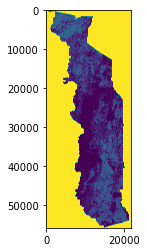

In [62]:
imstack1 = skio.imread("data\TogoBinaryMaps\AgreementMap_Togo_Binary.tif", plugin="tifffile")
plt.imshow(imstack1)
plt.show()